In [1]:
import pyaudio
import wave 
from time import sleep
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams 

In [21]:
watch_time=3
rec_time = 3            # 録音時間[s]

sleep(watch_time-1)

print("Rec starts after about 1s!")

sleep(1)

file_path = "./audio/violin.wav" #音声を保存するファイル名
fmt = pyaudio.paInt16  # 音声のフォーマット
ch = 1              # チャンネル1(モノラル)
sampling_rate = 44100 # サンプリング周波数
chunk = 2**11       # チャンク（データ点数）
audio = pyaudio.PyAudio()
index = 1 # 録音デバイスのインデックス番号（デフォルト1）

stream = audio.open(format=fmt, channels=ch, rate=sampling_rate, input=True,
                    input_device_index = index,
                    frames_per_buffer=chunk)
print("recording start...")

# 録音処理
frames = []
for i in range(0, int(sampling_rate / chunk * rec_time)):
    data = stream.read(chunk)
    frames.append(data)

print("recording  end...")

# 録音終了処理
stream.stop_stream()
stream.close()
audio.terminate()

# 録音データをファイルに保存
wav = wave.open(file_path, 'wb')
wav.setnchannels(ch)
wav.setsampwidth(audio.get_sample_size(fmt))
wav.setframerate(sampling_rate)
wav.writeframes(b''.join(frames))
wav.close()

Rec starts after about 1s!
recording start...
recording  end...


In [22]:
def wave_load(filename):
    # open wave file
    wf = wave.open(filename,'r')
    channels = wf.getnchannels()

    # load wave data
    chunk_size = wf.getnframes()
    amp  = (2**8) ** wf.getsampwidth() / 2
    data = wf.readframes(chunk_size)   # バイナリ読み込み
    data = np.frombuffer(data,'int16') # intに変換
    data = data / amp                  # 振幅正規化
    data = data[::channels]
   
    return data

In [23]:
def fft_load(st,size,filename):
    '''
    st = サンプリング開始位置 [s]
    size = FFTのサンプル数（２＊＊ｎ）
    filename = オーディオファイルのディレクトリ

    '''
    #st=44100*st
    
    
    hammingWindow = np.hamming(size)    # ハミング窓
    fs = 44100 #サンプリングレート
    d = 1.0 / fs #サンプリングレートの逆数
    freqList = np.fft.fftfreq(size, d)
    
    wave = wave_load(filename)
    #print(len(wave))
    
    #10000Hzごとにサンプルを10点取ってそれを平均したものを学習用の音声スペクトルデータとして用いる。
    for i in range(10):
        st=i*10000
        windowedData = hammingWindow * wave[st:st+size]  # 切り出した波形データ（窓関数あり）
        sample_data = np.fft.fft(windowedData)
        sample_data = sample_data / max(abs(sample_data)) # 0~1正規化
        if(i==0):
            data = sample_data
        else:
            data = (i*data+sample_data)/(i+1)
    
    data=abs(data)/max(abs(data))

    return data, freqList

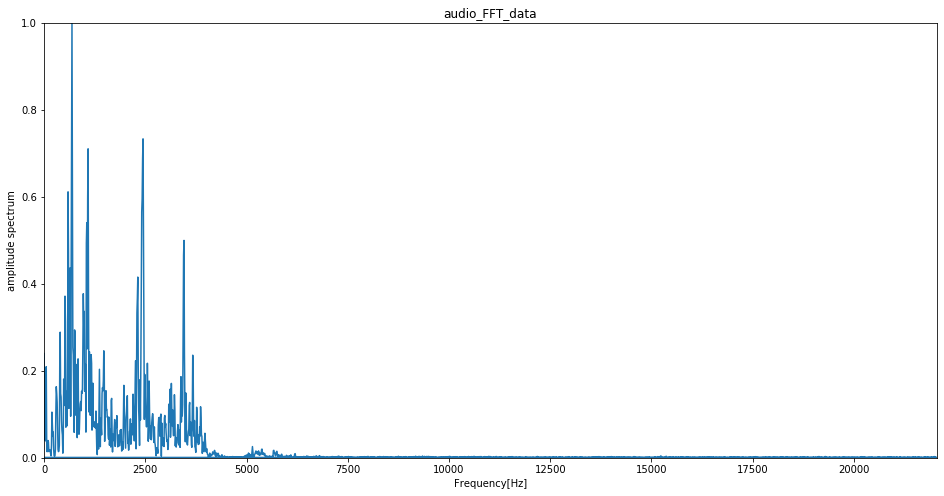

4096

In [24]:
violin_audio, freqList=fft_load(2, 2**12,"./audio/violin.wav")


rcParams["figure.figsize"]=16,8
plt.plot(freqList ,abs(violin_audio))
         
plt.axis([0,22050,0,1]) #第二引数でグラフのy軸方向の範囲指定
plt.title("audio_FFT_data")
plt.xlabel("Frequency[Hz]")
plt.ylabel("amplitude spectrum")
plt.show()

violin_audio.size